In [1]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# PyTorch related imports would go here
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
#from us import states
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
DATASET_NAME = "PM_AE6_v5.3_v10182024.csv"
#DATASET_NAME = "SpeciateV5.3_PM_All_Combustion_woMobile.csv"
#DATASET_NAME = "SpeciateV5.3_PM_All.csv"
df = pd.read_csv('/content/drive/MyDrive/usepa_speciate_V1/'+DATASET_NAME, encoding='ISO-8859-1')

In [56]:
df = df.pivot_table(index=['PROFILE_CODE', 'PROFILE_NAME'], columns='SPECIES_NAME', values='WEIGHT_PERCENT', aggfunc='first').reset_index()
# Fill NaN values with 0 (or any other value you prefer)
df = df.fillna(0)

In [57]:
columns_to_remove = ['Organic carbon I', 'Organic carbon II','Organic carbon III','Organic carbon IV','Elemental carbon I','Elemental carbon II','Elemental carbon III', 'Phosphate','Antimony','Bromine','Cadmium','Chlorine','Cobalt','Magnesium ion','Manganese','Mercury','Molybdenum','Selenium','Tin','Zirconium']

# Remove the selected columns
df = df.drop(columns=columns_to_remove)

In [58]:
def clean_text(text):
    # Remove numbers and special characters
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [ ]:
#df['OC/EC']=df['Organic carbon']/df['Elemental Carbon']
#df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [59]:
pivot_df = df
#description = df.describe()
df.describe()
#pivot_df.to_csv('AE6_pivot.csv')
# Write to CSV file
#description.to_csv('description.csv')

SPECIES_NAME,Aluminum,Ammonium,Arsenic,Calcium,Calcium ion,Chloride ion,Chromium,Copper,Elemental Carbon,Iron,...,Potassium ion,Pyrolyzed organic carbon,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Titanium,Vanadium,Zinc
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,1.244313,0.615458,0.017264,2.150591,0.017520,0.836298,0.039648,0.184802,7.003859,2.529436,...,0.306949,0.190734,3.101358,0.988666,0.030887,5.380986,1.396777,0.337386,0.022468,0.305624
std,2.858128,2.326338,0.181170,5.272874,0.110093,3.763782,0.161776,1.201367,13.221401,6.320189,...,1.077455,0.705173,6.103028,4.450717,0.188337,11.946127,3.513719,1.877687,0.130234,2.269960
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000476,0.000000,0.000000,0.000000,0.000059,0.357295,0.002382,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.014491,0.000000,0.000000,0.000000,0.000000
50%,0.016292,0.000000,0.000000,0.126092,0.000000,0.000000,0.000291,0.005857,2.500000,0.069870,...,0.000000,0.000000,0.056498,0.016000,0.000000,0.551475,0.101063,0.001500,0.000050,0.024608
75%,0.884000,0.169874,0.001000,1.103033,0.000000,0.074013,0.020000,0.027749,6.939719,2.340000,...,0.085982,0.000000,2.497812,0.180000,0.000000,3.594050,0.648175,0.061350,0.002000,0.090266
max,27.000000,22.016140,2.653243,30.000000,0.905882,41.036646,2.000000,17.095000,78.972650,49.880000,...,10.588235,5.296872,28.221500,39.920160,2.000000,60.000000,24.233333,25.500000,1.515625,32.999360


In [60]:
def assign_cluster_name(cluster):
    names = pivot_df[pivot_df['speciated_cluster'] == cluster]['PROFILE_NAME']
    most_common_name = Counter(names).most_common(1)[0][0]
    return most_common_name

In [61]:
X = pivot_df.iloc[:, 2:49]

In [62]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.sparse.linalg import svds

In [66]:
##### log transformation #####
import numpy as np
df_replace_zeros = X.replace(0, np.nan)

# Apply logarithm and ignore NaN
df_log = np.log(df_replace_zeros)  #**2

# Optionally, handle NaN values after logging (for instance, filling them with a specific value like 0 or mean)
# df_log_filled = df_log.fillna(0)  # Example: Filling NaN with 0
df_log_filled = df_log.fillna(df_log.min().min())  # Example: Filling NaN with minimum non-NaN value

# Perform SVD
U, S, VT = svds(df_log_filled.values,k=16)
X_svd = U @ np.diag(S) @ VT

In [ ]:
weights = {
'Chlorine':100,
'Bromine':100,
'Mercury':100,
'Magnesium ion':100,
'Zirconium':100,
'Selenium':100,
'Molybdenum':100,
'Cobalt':100,
'Arsenic':100,
'Calcium ion':100,
'Cadmium':10,
'Vanadium':10,
'Tin':10,
'Sodium ion':10,
'Antimony':10,
'Chromium':10,
'Nickel':10,
'Manganese':10,
'Lead':5,
'Phosphorus':5,
'Copper':5,
'Pyrolyzed organic carbon':5
}

# Apply weights to the selected columns
for column, weight in weights.items():
    X[column] *= weight

In [67]:
X.describe()

SPECIES_NAME,Aluminum,Ammonium,Arsenic,Calcium,Calcium ion,Chloride ion,Chromium,Copper,Elemental Carbon,Iron,...,Potassium ion,Pyrolyzed organic carbon,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Titanium,Vanadium,Zinc
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,1.244313,0.615458,0.017264,2.150591,0.017520,0.836298,0.039648,0.184802,7.003859,2.529436,...,0.306949,0.190734,3.101358,0.988666,0.030887,5.380986,1.396777,0.337386,0.022468,0.305624
std,2.858128,2.326338,0.181170,5.272874,0.110093,3.763782,0.161776,1.201367,13.221401,6.320189,...,1.077455,0.705173,6.103028,4.450717,0.188337,11.946127,3.513719,1.877687,0.130234,2.269960
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000476,0.000000,0.000000,0.000000,0.000059,0.357295,0.002382,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.014491,0.000000,0.000000,0.000000,0.000000
50%,0.016292,0.000000,0.000000,0.126092,0.000000,0.000000,0.000291,0.005857,2.500000,0.069870,...,0.000000,0.000000,0.056498,0.016000,0.000000,0.551475,0.101063,0.001500,0.000050,0.024608
75%,0.884000,0.169874,0.001000,1.103033,0.000000,0.074013,0.020000,0.027749,6.939719,2.340000,...,0.085982,0.000000,2.497812,0.180000,0.000000,3.594050,0.648175,0.061350,0.002000,0.090266
max,27.000000,22.016140,2.653243,30.000000,0.905882,41.036646,2.000000,17.095000,78.972650,49.880000,...,10.588235,5.296872,28.221500,39.920160,2.000000,60.000000,24.233333,25.500000,1.515625,32.999360


In [ ]:
# Apply SVD to X
U, S, VT = svds(X.values, k=16)
X_svd = U @ np.diag(S) @ VT

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
X_pca=pca.fit_transform(X.values)

In [68]:
X=X_svd
#X=X_pca

In [ ]:
X

array([[  0.88199867,  -7.53481112,   2.38609838, ...,  -5.9129986 ,
         -0.16270071,  -6.89791222],
       [  1.00995996,  -7.61126784,   2.41232218, ...,  -5.92859931,
         -0.15633306,  -7.22199789],
       [  1.00258075,  -7.6048824 ,   2.39753913, ...,  -5.71431818,
         -0.06418924,  -6.56750567],
       ...,
       [  2.09532546,  -2.646703  ,  -4.29329614, ...,  -6.25694524,
         -1.84670652,  -6.39439311],
       [  3.25090945,  -4.41855006, -10.70749269, ...,  -1.83407163,
         -2.85767121,  -2.32026189],
       [  2.94330497,  -2.62584365, -15.02809652, ...,  -0.99728271,
         -1.72696273,  -2.98564768]])

In [79]:
K = 5
knn = NearestNeighbors(n_neighbors=K)  # You can change the number of neighbors
knn.fit(X)
distances, indices = knn.kneighbors(X)

# Create a graph
G = nx.Graph()

# Add nodes with PROFILE_NAME as labels
for i, profile_name in enumerate(df['PROFILE_NAME']):
    G.add_node(i, label=profile_name)

# Add edges based on KNN
for i, neighbors in enumerate(indices):
    for neighbor in neighbors:
        if i != neighbor:  # Avoid self-loops
            G.add_edge(i, neighbor)

In [70]:
import matplotlib
matplotlib.use('Agg')  # Use a non-interactive backend

In [32]:
pip install cdlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.6/263.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.1 MB/s eta 0:00:00


In [80]:
import cdlib
from cdlib import algorithms
import networkx as nx
# G = nx.karate_club_graph()

# non-overlap louvain
coms = algorithms.louvain(G, weight='weight', resolution=1., randomize=False)

In [81]:
com_map={}

for i in range(len(coms.communities)):
    community = coms.communities[i]
    for j in community:
        com_map[j] = i


coms_l = [algorithms.louvain(G), algorithms.label_propagation(G), algorithms.walktrap(G)]
overlap_coms = algorithms.endntm(G, coms_l)

In [82]:
overlap_com_map={}

for i in range(len(overlap_coms.communities)):
    community = overlap_coms.communities[i]
    for j in community:
        if j in overlap_com_map:
            overlap_com_map[j].append(i)
        else:
            overlap_com_map[j] = [i]


In [85]:

labels=[]
# y = [i+'-'+j for i,j in zip(pivot_df['PROFILE_NAME'],pivot_df['PROFILE_CODE'])]
y = [str(i) for i in pivot_df['PROFILE_CODE']]
labels = dict(zip(range(len(y)), y))

print(labels)

overlap_com_map_str = {key: ",".join([str(i) for i in value]) for key, value in overlap_com_map.items()}

nx.set_node_attributes(G, labels, 'labels')
nx.set_node_attributes(G, com_map, 'non_overlap_community')
nx.set_node_attributes(G, overlap_com_map_str, 'overlap_community')

filename = DATASET_NAME+"KNN"+str(K)+'.gexf'
print("Writing gephi...."+filename)
#nx.write_gexf(G, filename)
print("Done....")

{0: '3766AE6', 1: '5674', 2: '5675AE6', 3: '8873AE6', 4: '8898a', 5: '8901a', 6: '8902a', 7: '8992', 8: '8993', 9: '8994', 10: '8995', 11: '8996', 12: '91100', 13: '91101', 14: '91102', 15: '91103', 16: '91104', 17: '91105', 18: '91106', 19: '91107', 20: '91108', 21: '91109', 22: '91110', 23: '91111', 24: '91112', 25: '91113', 26: '91114', 27: '91115', 28: '91116', 29: '91117', 30: '91118', 31: '91119', 32: '91120', 33: '91121', 34: '91122', 35: '91123', 36: '91124', 37: '91125', 38: '91126', 39: '91127', 40: '91128', 41: '91129', 42: '91130', 43: '91131', 44: '91132', 45: '91133', 46: '91134', 47: '91135', 48: '91136', 49: '91137', 50: '91138', 51: '91139', 52: '91140', 53: '91141', 54: '91142', 55: '91143', 56: '91144', 57: '91145', 58: '91146', 59: '91147', 60: '91148', 61: '91149', 62: '91150', 63: '91151', 64: '91152', 65: '91153', 66: '91154', 67: '91155', 68: '91156', 69: '91157', 70: '91158', 71: '91159', 72: '91160', 73: '91161', 74: '91162', 75: '91163', 76: '91164', 77: '911

In [86]:

data = {
    'Row Number': list(range(len(pivot_df))),
    'PROFILE_CODE': pivot_df['PROFILE_CODE'],
    'PROFILE_NAME': pivot_df['PROFILE_NAME'],
    'Community Number': [com_map[row] for row in range(len(pivot_df))],
    'Overlapping Community': [overlap_com_map_str[row] for row in range(len(pivot_df))]
}

result_df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
file_name = DATASET_NAME+"_KNN"+str(K)+'_community_info.csv'
result_df.to_csv(file_name, index=False)
print("Saved in ",file_name)

Saved in  PM_AE6_v5.3_v10182024.csv_KNN5_community_info.csv


In [87]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# This magic command ensures that plots are shown inline in Jupyter Notebook
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, NMF

cluster_number = len(coms.communities)
print(cluster_number)


13


In [89]:
for i, cluster in enumerate(coms.communities):
    selected_rows = pivot_df.loc[cluster]

    fig, ax = plt.subplots(figsize=(18, 8))
    selected_rows.iloc[:, 2:45].boxplot(ax=ax, grid=False)
    ax.grid(False)
    #plt.yscale('log') # saikat
    plt.title(f"Boxplot for Cluster '{i}'")
    plt.xticks(rotation=90)  # Rotate x-labels if needed

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(ax)
    ax_table = divider.append_axes("right", size="20%", pad=0.00)

    # Hide the axes for the table
    ax_table.axis('off')

    # Create the table
    table_data = selected_rows[['PROFILE_NAME']]
    table = ax_table.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='left', loc='right')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(2, 2)
    plt.tight_layout()
    #fig.savefig(f'plot_{i+1}.png')
    plt.plot()
    #plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [42]:
k_species = 10


for i, cluster in enumerate(coms.communities):

    selected_rows = pivot_df.loc[cluster]

    selected_columns = selected_rows.iloc[:,2:45]



    U, S, Vt = np.linalg.svd(selected_columns, full_matrices=False)


    column_importance = np.sum(np.matmul(np.diag(S),Vt**2), axis=0)

    important_columns_indices = np.argsort(-column_importance)[:k_species]

    important_columns = selected_columns.columns[important_columns_indices]

    print(important_columns)
    column_importance_per = column_importance/np.sum(column_importance)*100
    #print(np.sort(column_importance_per)[::-1])

    print(selected_rows[important_columns].describe())

    fig, ax = plt.subplots(figsize=(18, 8))
    ax.boxplot(selected_rows[important_columns])


    ax.grid(False)
    ax.set_xticklabels(important_columns, rotation=90)
    #plt.yscale("log")
    plt.title(f"Boxplot for key species in cluster '{i}'")
    plt.xticks(rotation=90)  # Rotate x-labels if needed

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(ax)
    ax_table = divider.append_axes("right", size="20%", pad=0.0)

    # Hide the axes for the table
    ax_table.axis('off')

    # Create the table
    table_data = selected_rows[['PROFILE_NAME']]
    table = ax_table.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='left', loc='right')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(2, 2)
    plt.tight_layout()
    fig.savefig(f'plot_{i+1}.png')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
selected_rows


SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
146,95514,Coal Combustion - Prater Creek Coal,11.8994,1.30030,0.0,0.01928,0.0,0.00000,0.37622,0.0,...,0.0,0.04740,0.0,5.0780,0.0,0.0,0.0,0.04604,0.02446,0.0
147,95515,Coal Combustion - Prater Creek w/biomass,0.0000,0.10058,0.0,0.01303,0.0,0.00046,1.43590,0.0,...,0.0,0.16318,0.0,2.8749,0.0,0.0,0.0,0.03742,0.03043,0.0
148,95516,Coal Combustion - Black Thunder Coal,0.0000,0.01904,0.0,0.00454,0.0,0.00028,2.88210,0.0,...,0.0,0.15797,0.0,3.5381,0.0,0.0,0.0,0.03122,0.01595,0.0
149,95517,Coal Combustion - Bailey Mine Coal,0.0000,3.77660,0.0,0.00951,0.0,0.00000,0.52095,0.0,...,0.0,0.05867,0.0,36.1690,0.0,0.0,0.0,0.02619,0.01250,0.0


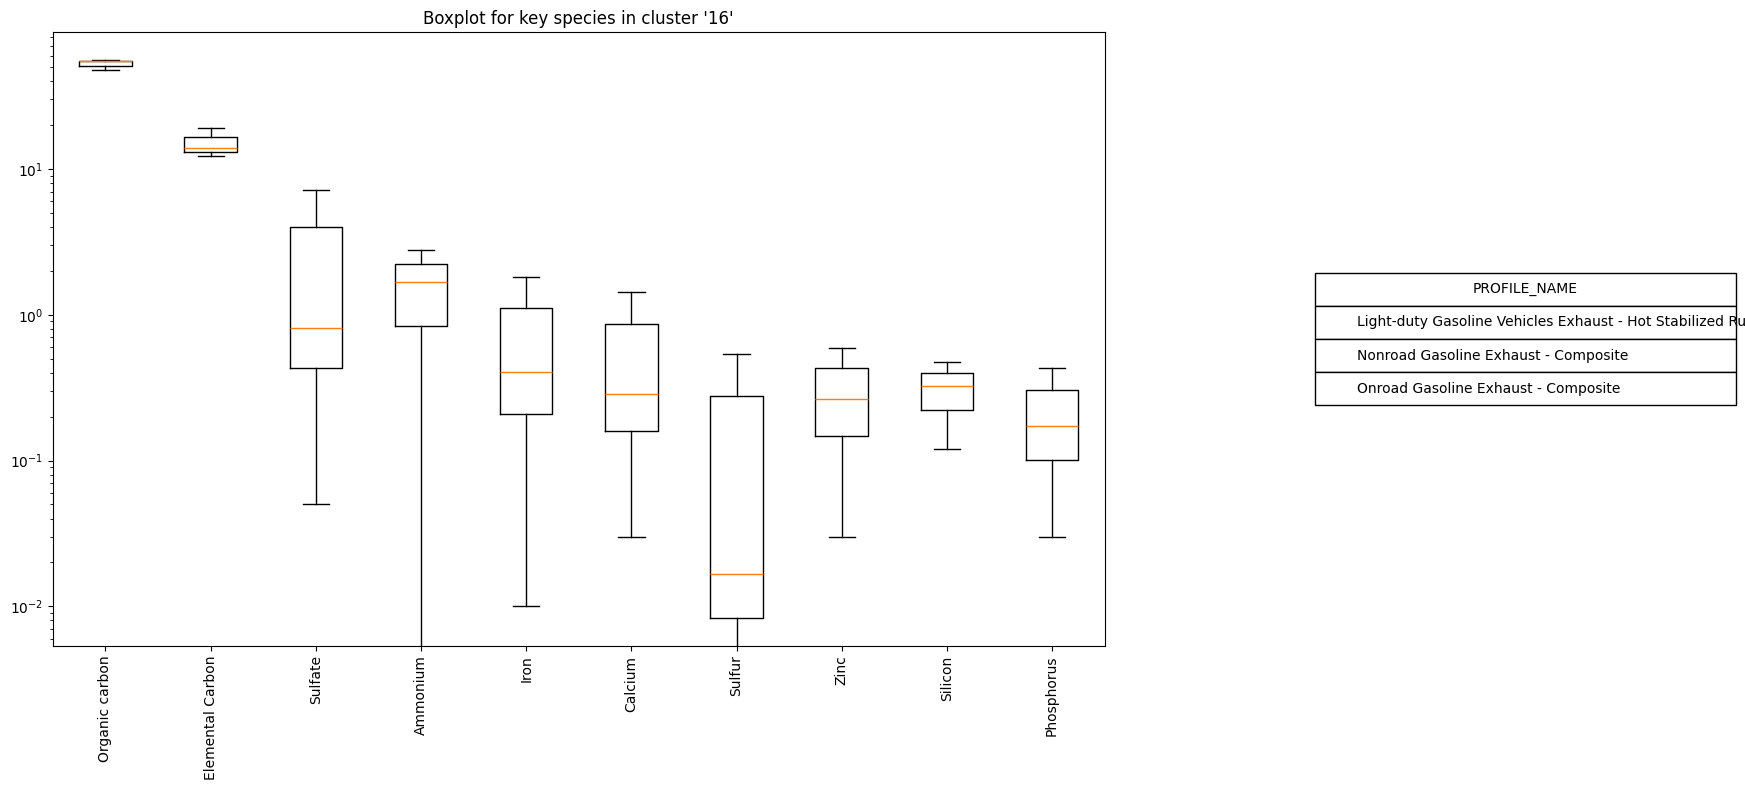

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

k_species = 10
# Subset the DataFrame based on the value of the second column (index=1)
conditions = (pivot_df['PROFILE_CODE'] == '8993') | (pivot_df['PROFILE_CODE'] == '91113') | (pivot_df['PROFILE_CODE'] == '91122')
selected_rows = pivot_df[conditions]
selected_columns = selected_rows.iloc[:,2:45]
# Create a boxplot for all columns except the first two
#subset_df.iloc[:, 3:].boxplot()
U, S, Vt = np.linalg.svd(selected_columns, full_matrices=False)
column_importance = np.sum(Vt**2, axis=0)
important_columns_indices = np.argsort(-column_importance)[:k_species]
important_columns = selected_columns.columns[important_columns_indices]
fig, ax = plt.subplots(figsize=(18, 8))
ax.boxplot(selected_rows[important_columns])
ax.grid(False)
ax.set_xticklabels(important_columns, rotation=90)
plt.yscale('log')
plt.title(f"Boxplot for key species in cluster '{i}'")
plt.xticks(rotation=90)  # Rotate x-labels if needed

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
ax_table = divider.append_axes("right", size="20%", pad=0.0)

# Hide the axes for the table
ax_table.axis('off')

# Create the table
table_data = selected_rows[['PROFILE_NAME']]
table = ax_table.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='left', loc='right')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(2, 2)
plt.tight_layout()
#fig.savefig(f'plot_{i+1}.png')
plt.show()
#95125a


In [ ]:
pivot_df

SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,3766AE6,Forest Fire - AE6,0.015400,0.110500,0.000500,0.000300,0.0,0.000100,0.369300,0.0,...,0.062000,0.012200,0.0,0.133200,0.0792,0.001500,0.001500,0.000100,0.002900,0.000000
1,5674,Marine Vessel - Main Engine - Heavy Fuel Oil,0.771625,0.000000,0.019000,0.000000,0.0,0.003958,0.259125,0.0,...,0.000000,0.000000,0.0,38.032500,0.0000,0.013281,0.005000,1.515625,0.018250,0.000000
2,5675AE6,Marine Vessel - Auxiliary Engine - Marine Gas ...,0.000000,0.000000,0.061466,0.000000,0.0,0.023641,1.912530,0.0,...,0.340426,0.000000,0.0,12.078014,0.0000,0.035461,0.014184,0.082742,0.200946,0.000000
3,8873AE6,Aircraft Exhaust,0.000000,1.791897,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,6.867400,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8898a,Outdoor Hydronic Heater- one stage updraft con...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.017300,0.010700,0.0,0.044100,0.0147,0.000000,0.000000,0.000000,0.007760,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,95870,Catalytic Woodstove Startup Wood Composite,0.000000,0.000000,0.001704,0.000111,0.0,0.006554,0.056238,0.0,...,0.026435,0.045670,0.0,0.417652,0.0000,0.010290,0.001487,0.000154,0.045448,0.000927
215,95871,Catalytic Woodstove Burn Phase Composite Birch,0.000000,0.000000,0.010937,0.000005,0.0,0.006001,0.024024,0.0,...,0.101690,0.021691,0.0,1.906428,0.0000,0.008238,0.000061,0.000311,0.183862,0.000196
216,95872,Catalytic Woodstove Burn Phase Composite Spruce,0.000355,0.000000,0.000725,0.000006,0.0,0.002385,0.043209,0.0,...,0.001333,0.003175,0.0,0.359246,0.0000,0.001160,0.000393,0.000060,0.032112,0.000267
217,95873,Catalytic Woodstove Burn Phase and Wood Composite,0.000149,0.000000,0.006648,0.000006,0.0,0.004483,0.032082,0.0,...,0.059540,0.013915,0.0,1.256611,0.0000,0.005265,0.000200,0.000206,0.120127,0.000226
